In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
import os

import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in Train Val Test
train_imgs = []
train_labels = []
for img, label in zip(sorted(os.listdir('train/img')), sorted(os.listdir('train/label'))):
    train_imgs.append(np.array(Image.open('train/img/'+img)).astype(float))
    train_labels.append(np.array(Image.open('train/label/'+label)).astype(float))
    
val_imgs = []
val_labels = []
for img, label in zip(sorted(os.listdir('val/img')), sorted(os.listdir('val/label'))):
    val_imgs.append(np.array(Image.open('val/img/'+img)).astype(float))
    val_labels.append(np.array(Image.open('val/label/'+label)).astype(float))
    
test_imgs = []
test_labels = []
for img, label in zip(sorted(os.listdir('test/img')), sorted(os.listdir('test/label'))):
    test_imgs.append(np.array(Image.open('test/img/'+img)).astype(float))
    test_labels.append(np.array(Image.open('test/label/'+label)).astype(float))


# 一定要把img转float，原始的unit8加减乘除会出错

In [3]:
train_imgs[0].shape

(265, 553, 4)

# Data Preprocessing

In [4]:
# have a look at train test imgs and labels
'''
plt.figure(figsize=(6, 6))
i = 0
for img, title in zip([train_img, train_label, test_img, test_label], 
                      ['train img', 'train label', 'test img', 'test label']):
    ax = plt.subplot(2, 2, i + 1)
    i += 1
    plt.imshow(img.astype("uint8")) # 0-255 unsigned integer
    plt.title(title)
    plt.axis("off") # 不plot axis
        
plt.show()
'''

'\nplt.figure(figsize=(6, 6))\ni = 0\nfor img, title in zip([train_img, train_label, test_img, test_label], \n                      [\'train img\', \'train label\', \'test img\', \'test label\']):\n    ax = plt.subplot(2, 2, i + 1)\n    i += 1\n    plt.imshow(img.astype("uint8")) # 0-255 unsigned integer\n    plt.title(title)\n    plt.axis("off") # 不plot axis\n        \nplt.show()\n'

In [5]:
# add NDVI

def find_ndvi(pix):
    return (pix[3] - pix[0])/(pix[3] + pix[0]) if pix[3] + pix[0] !=0 else 0.0

def add_ndvi(img):
    v_find_ndvi = np.vectorize(find_ndvi, signature = '(n)->()')
    return np.append(img, 
                     np.expand_dims(v_find_ndvi(img), axis = 2),
                     axis = 2)

for i in range(len(train_imgs)):
    train_imgs[i] = add_ndvi(train_imgs[i])
    
for i in range(len(val_imgs)):
    val_imgs[i] = add_ndvi(val_imgs[i])
    
for i in range(len(test_imgs)):
    test_imgs[i] = add_ndvi(test_imgs[i])

In [6]:
train_imgs[0].shape

(265, 553, 5)

In [7]:
# create padding indicator matrix

def not_padding(pix):
    return 1.0*np.any(np.array(pix) != 0) # 利用broadcast机制 如果rgb nir全是0就是padding

def valid_ind(img):
    v_find_valid = np.vectorize(not_padding, signature = '(n)->()')
    return v_find_valid(img)

train_valids = []
for i in range(len(train_imgs)):
    train_valids.append(valid_ind(train_imgs[i]))

val_valids = []
for i in range(len(val_imgs)):
    val_valids.append(valid_ind(val_imgs[i]))
    
test_valids = []
for i in range(len(test_imgs)):
    test_valids.append(valid_ind(test_imgs[i]))
    

'''
ax = plt.subplot(1, 2, 1)
plt.imshow(train_valid) # 0-1 float
plt.title('valid region for train img')
plt.axis("off")

ax = plt.subplot(1, 2, 2)
plt.imshow(test_valid) # 0-1 float
plt.title('valid region for test img')
plt.axis("off")

plt.show()
'''

'\nax = plt.subplot(1, 2, 1)\nplt.imshow(train_valid) # 0-1 float\nplt.title(\'valid region for train img\')\nplt.axis("off")\n\nax = plt.subplot(1, 2, 2)\nplt.imshow(test_valid) # 0-1 float\nplt.title(\'valid region for test img\')\nplt.axis("off")\n\nplt.show()\n'

In [8]:
# Image to DataFrame

train_df = pd.DataFrame(columns = ['x', 'y', 'idx'])
for i in range(len(train_imgs)):
    x = pd.DataFrame({'x': range(0, len(train_imgs[i]))})
    y = pd.DataFrame({'y': range(0, len(train_imgs[i][0]))})
    df = x.assign(foo = 1).merge(y.assign(foo = 1), on = 'foo').drop(columns = ['foo'])
    df['idx'] = i

    train_df = train_df.append(df, ignore_index = True)

val_df = pd.DataFrame(columns = ['x', 'y', 'idx'])
for i in range(len(val_imgs)):
    x = pd.DataFrame({'x': range(0, len(val_imgs[i]))})
    y = pd.DataFrame({'y': range(0, len(val_imgs[i][0]))})
    df = x.assign(foo = 1).merge(y.assign(foo = 1), on = 'foo').drop(columns = ['foo'])
    df['idx'] = i

    val_df = val_df.append(df, ignore_index = True)

test_df = pd.DataFrame(columns = ['x', 'y', 'idx'])
for i in range(len(test_imgs)):
    x = pd.DataFrame({'x': range(0, len(test_imgs[i]))})
    y = pd.DataFrame({'y': range(0, len(test_imgs[i][0]))})
    df = x.assign(foo = 1).merge(y.assign(foo = 1), on = 'foo').drop(columns = ['foo'])
    df['idx'] = i

    test_df = test_df.append(df, ignore_index = True)

train_df.shape, val_df.shape, test_df.shape

((286146, 3), (102265, 3), (259021, 3))

In [9]:
# add basic features and label

def prepare_df(img, df, labels, valid):
    df = df.copy()
    
    # Extract the basic information of each pixel, which contains r, g, b, NIR and NDVI.
    df[['r', 'g', 'b', 'NIR', 'NDVI']] = pd.DataFrame(np.stack(df.apply(
        lambda x:img[int(x['idx'])][int(x['x']), int(x['y'])].astype(float), axis = 1)))
    
    # add label and mark out false positives
    df['label'] = df.apply(
        lambda x: 2 if (labels[int(x['idx'])][int(x['x']), int(x['y'])] == 1) and (x['NDVI'] < 0.3) 
        else labels[int(x['idx'])][int(x['x']), int(x['y'])]
        , axis=1)
    
    # mark out padding areas
    df['is_valid'] = df.apply(lambda x:valid[int(x['idx'])][int(x['x']), int(x['y'])], axis = 1)
    
    return df

train_df = prepare_df(train_imgs, train_df, train_labels, train_valids)
val_df = prepare_df(val_imgs, val_df, val_labels, val_valids)
test_df = prepare_df(test_imgs, test_df, test_labels, test_valids)
train_df.shape, val_df.shape, test_df.shape

((286146, 10), (102265, 10), (259021, 10))

In [10]:
# have a look at valid pixels

print('train valid summary:')
print(train_df['is_valid'].value_counts(),'\n')
print('val valid summary:')
print(val_df['is_valid'].value_counts(),'\n')
print('test valid summary:')
print(test_df['is_valid'].value_counts())

train valid summary:
1.0    275788
0.0     10358
Name: is_valid, dtype: int64 

val valid summary:
1.0    89026
0.0    13239
Name: is_valid, dtype: int64 

test valid summary:
1.0    209850
0.0     49171
Name: is_valid, dtype: int64


In [11]:
# only take valid pixels with correct labels

train_df = train_df[train_df['label'] < 2] 
val_df = val_df[val_df['label'] < 2] 
test_df = test_df[test_df['label'] < 2]

# clean padding region
train_df = train_df[train_df['is_valid'] == 1].reset_index(drop = True) 
val_df = val_df[val_df['is_valid'] == 1].reset_index(drop = True) 
test_df = test_df[test_df['is_valid'] == 1].reset_index(drop = True)

print('train label summary:')
print(train_df['label'].value_counts(),'\n')
print('val label summary:')
print(val_df['label'].value_counts(),'\n')
print('test label summary:')
print(test_df['label'].value_counts())

train label summary:
0.0    202068
1.0     55472
Name: label, dtype: int64 

val label summary:
0.0    69079
1.0    12950
Name: label, dtype: int64 

test label summary:
0.0    153000
1.0     39517
Name: label, dtype: int64


In [12]:
train_df

,x,y,idx,r,g,b,NIR,NDVI,label,is_valid
0,0,0,0,84.0,91.0,94.0,58.0,-0.183099,0.0,1.0
1,0,1,0,91.0,98.0,100.0,89.0,-0.011111,0.0,1.0
2,0,2,0,101.0,107.0,99.0,132.0,0.133047,0.0,1.0
3,0,3,0,93.0,101.0,90.0,141.0,0.205128,0.0,1.0
4,0,4,0,86.0,96.0,87.0,137.0,0.228700,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
257535,342,400,1,87.0,91.0,95.0,55.0,-0.225352,0.0,1.0
257536,342,401,1,85.0,90.0,94.0,54.0,-0.223022,0.0,1.0
257537,342,402,1,86.0,90.0,95.0,51.0,-0.255474,0.0,1.0
257538,342,403,1,87.0,92.0,95.0,54.0,-0.234043,0.0,1.0


In [13]:
# add features and label

def find_area(img, x, y, d=2):
    return img[max(0, x-d):x+d+1, max(0, y-d):y+d+1].astype(float)


def add_features(img, df, valid, d=2):
    df = df.copy()

    # Extract the information of surrounding pixels ofeach pixel, including min, max, average, std of basic information.
    
    # Idea - keep valid pixels as is, transform invalid pixels to nan
    # Method - use inf*0 = nan, min(nan, num) = nan, min(inf, num) = num to transform
    
    df[['r_avg', 'g_avg', 'b_avg', 'NIR_avg', 'NDVI_avg']] = pd.DataFrame(np.stack(
        df.apply(
            lambda x:np.nanmean(
                np.min(
                    [find_area(img[int(x['idx'])], int(x['x']), int(x['y']), d)
                     , np.dstack([find_area(valid[int(x['idx'])], int(x['x']), int(x['y']), d)*float('inf')]*5)]
                    , axis = 0)
                , axis = (0,1))
            , axis = 1)))
    
    # 前面如果没有给df reset index 这步会出bug 因为index mismatch

    df[['r_min', 'g_min', 'b_min', 'NIR_min', 'NDVI_min']] = pd.DataFrame(np.stack(
        df.apply(
            lambda x:np.nanmin(
                np.min(
                    [find_area(img[int(x['idx'])], int(x['x']), int(x['y']), d)
                     , np.dstack([find_area(valid[int(x['idx'])], int(x['x']), int(x['y']), d)*float('inf')]*5)]
                    , axis = 0)
                , axis = (0,1))
            , axis = 1)))

    df[['r_max', 'g_max', 'b_max', 'NIR_max', 'NDVI_max']] = pd.DataFrame(np.stack(
        df.apply(
            lambda x:np.nanmax(
                np.min(
                    [find_area(img[int(x['idx'])], int(x['x']), int(x['y']), d)
                     , np.dstack([find_area(valid[int(x['idx'])], int(x['x']), int(x['y']), d)*float('inf')]*5)]
                    , axis = 0)
                , axis = (0,1))
            , axis = 1)))
    
    df[['r_std', 'g_std', 'b_std', 'NIR_std', 'NDVI_std']] = pd.DataFrame(np.stack(
        df.apply(
            lambda x:np.nanstd(
                np.min(
                    [find_area(img[int(x['idx'])], int(x['x']), int(x['y']), d)
                     , np.dstack([find_area(valid[int(x['idx'])], int(x['x']), int(x['y']), d)*float('inf')]*5)]
                    , axis = 0)
                , axis = (0,1))
            , axis = 1)))
    return df

train_df = add_features(train_imgs, train_df, train_valids, 2)
val_df = add_features(val_imgs, val_df, val_valids, 2)
test_df = add_features(test_imgs, test_df, test_valids, 2)

train_df.shape, val_df.shape, test_df.shape

((257540, 30), (82029, 30), (192517, 30))

In [14]:
train_df

,x,y,idx,r,g,b,NIR,NDVI,label,is_valid,...,r_max,g_max,b_max,NIR_max,NDVI_max,r_std,g_std,b_std,NIR_std,NDVI_std
0,0,0,0,84.0,91.0,94.0,58.0,-0.183099,0.0,1.0,...,108.0,115.0,112.0,140.0,0.161826,8.730534,8.666667,5.964918,29.129765,0.114075
1,0,1,0,91.0,98.0,100.0,89.0,-0.011111,0.0,1.0,...,108.0,115.0,112.0,152.0,0.230769,7.653521,7.584249,6.409086,31.292970,0.131516
2,0,2,0,101.0,107.0,99.0,132.0,0.133047,0.0,1.0,...,108.0,115.0,112.0,152.0,0.301724,8.386232,7.568942,7.833262,30.383036,0.141369
3,0,3,0,93.0,101.0,90.0,141.0,0.205128,0.0,1.0,...,108.0,115.0,112.0,152.0,0.393365,12.531915,10.898726,11.701092,16.463562,0.109012
4,0,4,0,86.0,96.0,87.0,137.0,0.228700,0.0,1.0,...,107.0,115.0,106.0,152.0,0.443850,15.859662,14.249522,12.113170,7.352702,0.091325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257535,342,400,1,87.0,91.0,95.0,55.0,-0.225352,0.0,1.0,...,93.0,94.0,101.0,63.0,-0.192308,2.093376,1.299573,1.611073,2.976948,0.018462
257536,342,401,1,85.0,90.0,94.0,54.0,-0.223022,0.0,1.0,...,89.0,93.0,97.0,58.0,-0.197183,1.619328,1.123487,0.909212,1.995551,0.015370
257537,342,402,1,86.0,90.0,95.0,51.0,-0.255474,0.0,1.0,...,89.0,94.0,98.0,57.0,-0.197183,1.540563,1.460593,1.135292,1.651935,0.013181
257538,342,403,1,87.0,92.0,95.0,54.0,-0.234043,0.0,1.0,...,89.0,94.0,98.0,57.0,-0.213793,1.598611,1.605113,1.247219,1.545603,0.010677


# EDAV

In [15]:
features = ['r', 'g', 'b', 'NIR', 'NDVI', 'r_avg',
       'g_avg', 'b_avg', 'NIR_avg', 'NDVI_avg', 'r_min', 'g_min', 'b_min',
       'NIR_min', 'NDVI_min', 'r_max', 'g_max', 'b_max', 'NIR_max', 'NDVI_max',
       'r_std', 'g_std', 'b_std', 'NIR_std', 'NDVI_std']

label = 'label'

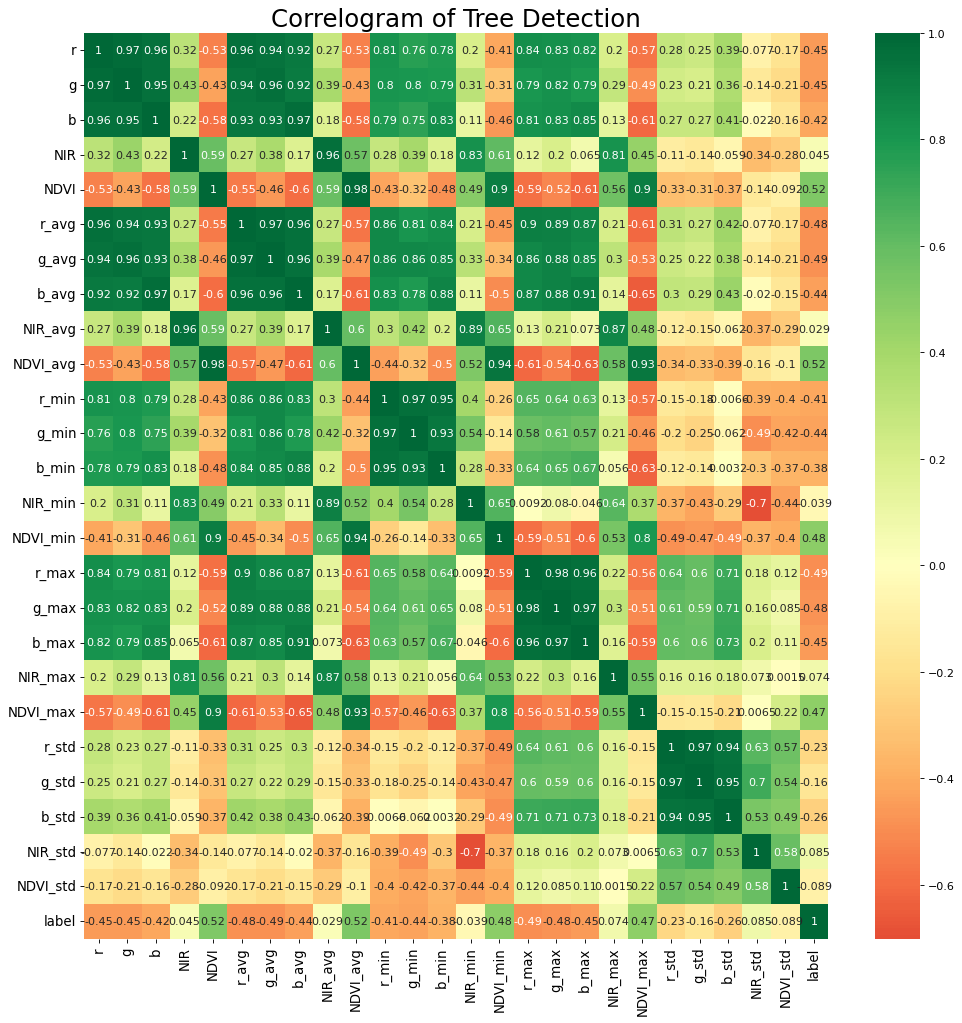

In [16]:
plt.figure(figsize = (15,15), dpi = 80)
sns.heatmap(train_df[features+[label]].corr(), 
            xticklabels = features+[label], yticklabels = features+[label], cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram of Tree Detection', fontsize = 22)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

In [17]:
# 为什么rgb直接highly correlated?

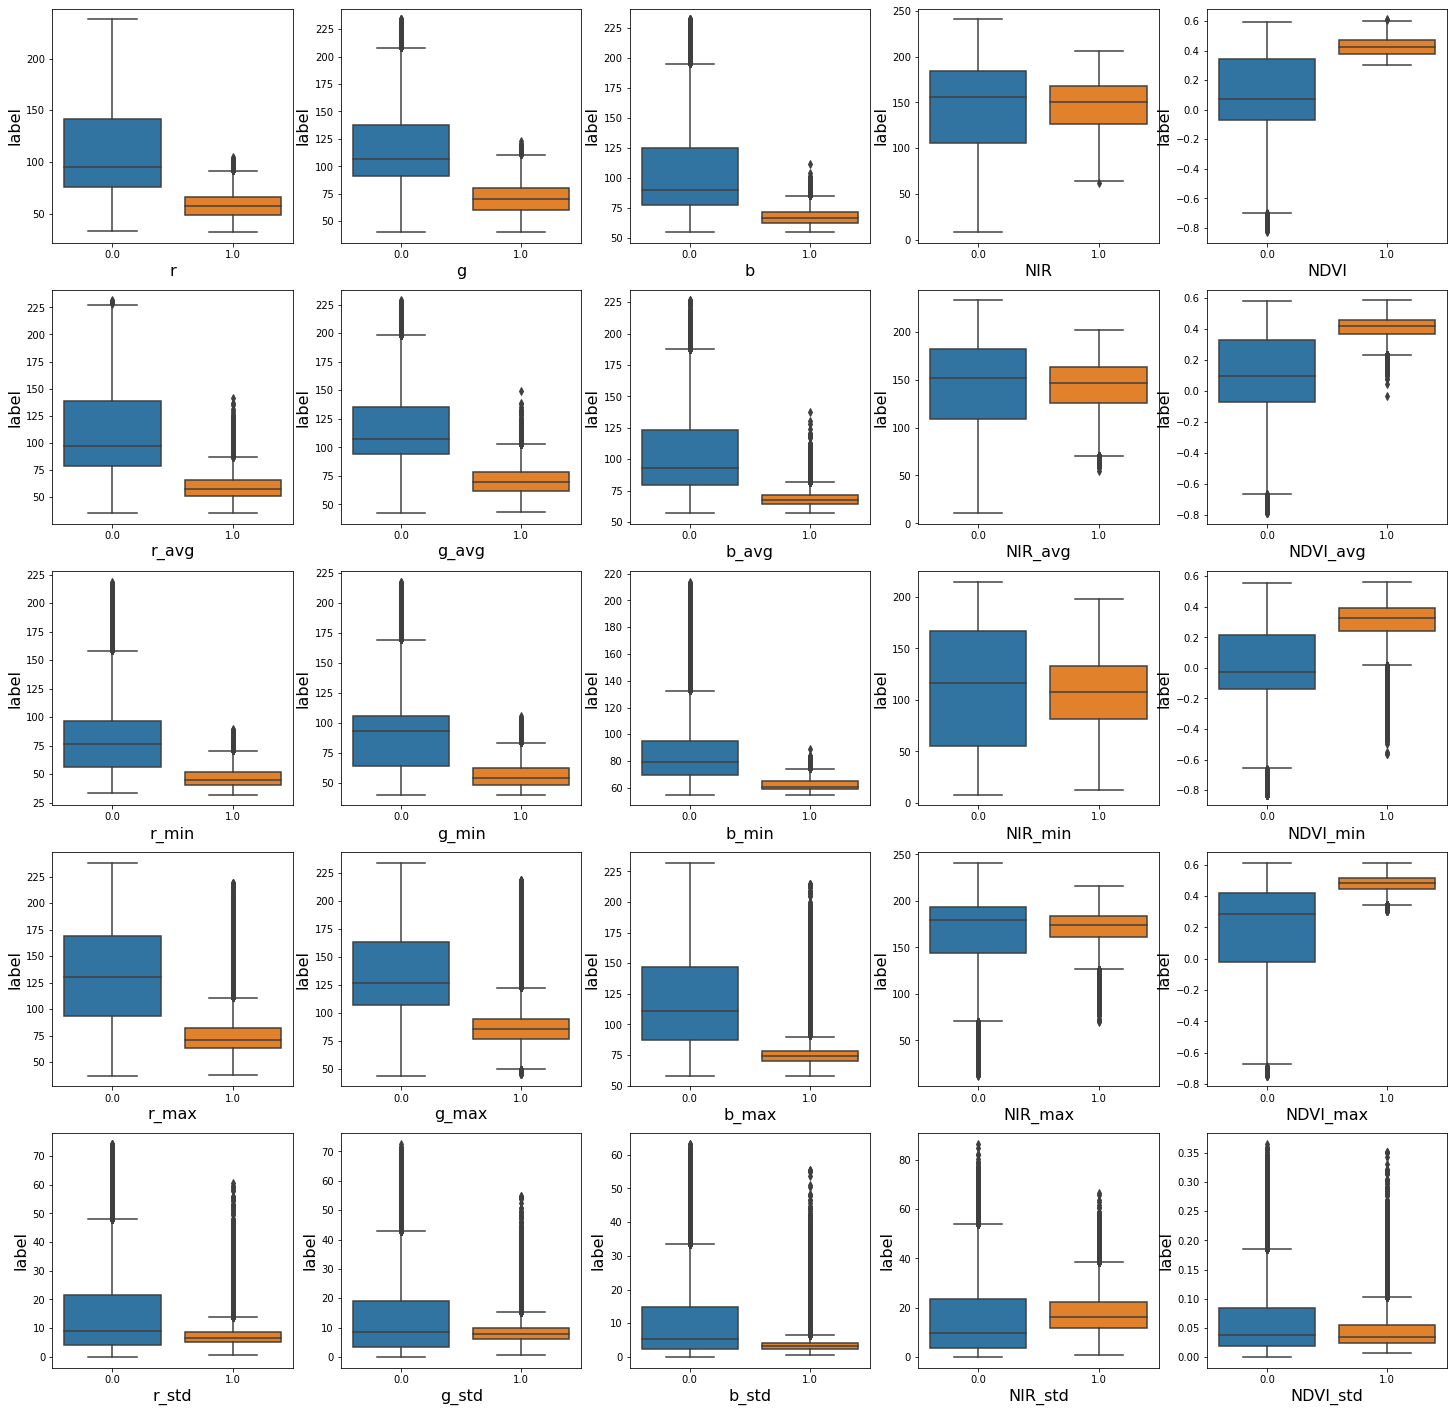

In [18]:
fig, ax = plt.subplots(5, 5, figsize = (25, 25))
for fea, subplot in zip(features, ax.flatten()): # flatten makes ax an 1-D iterator
    sns.boxplot(x = label, y = fea, data = train_df, ax = subplot)
    subplot.set_xlabel(fea, fontsize = 16)
    subplot.set_ylabel(label, fontsize = 16)
    
plt.show()

# Model Training & Evaluation

In [19]:
# build model
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
from sklearn.model_selection import train_test_split

from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.impute import SimpleImputer

from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score

from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC, SVC

from sklearn.ensemble import RandomForestClassifier

import shap

In [20]:
model = {}
model['logreg'] = Pipeline([('scaler', RobustScaler()), 
                        ('model', LogisticRegression())])

model['svm'] = Pipeline([('scaler', RobustScaler()), 
                        ('model', LinearSVC())])
# 如果不进行non linear mapping，数据量大用linearSVC不用SVC with linear kernel

model['rf'] = Pipeline([('scaler', RobustScaler()), 
                        ('model', RandomForestClassifier(random_state = 42))])

model['xgb']= Pipeline([('scaler', RobustScaler()), 
                        ('model', xgb.XGBClassifier(verbosity = 0, random_state = 42))])

In [21]:
# 算不算label 2???现在没算

for model_name in model:
    model[model_name].fit(train_df[features], train_df[label])
    print('default '+model_name+':')
    print('Train IoU:', jaccard_score(train_df[label], model[model_name].predict(train_df[features])))
    print('Val IoU:', jaccard_score(val_df[label], model[model_name].predict(val_df[features])))
    print('Test IoU:', jaccard_score(test_df[label], model[model_name].predict(test_df[features])),'\n')

default logreg:
Train IoU: 0.7298963908974239
Val IoU: 0.6505148005148005
Test IoU: 0.7034140201829501 

default svm:
Train IoU: 0.7329129373474369
Val IoU: 0.6504399203647807
Test IoU: 0.705629749539098 

default rf:
Train IoU: 1.0
Val IoU: 0.700236890966131
Test IoU: 0.7579984501273109 

default xgb:
Train IoU: 0.8632083156831438
Val IoU: 0.6994611727416798
Test IoU: 0.7616112700858464 



In [28]:
# Hyperparameter tuning with bayesian optimization - optuna
import optuna

train_x, test_x, train_y, test_y = train_df[features], val_df[features], train_df[label], val_df[label]

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=train_y)

# 可以tune
threshold_ = 0.5

def IoU(predt, dtrain):
    y = dtrain.get_label()
    return 'IoU', jaccard_score(y, predt > threshold_)

def objective(trial):
    
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.02,0.04,0.06,0.08,0.1,0.2]),
        'n_estimators': trial.suggest_categorical('n_estimators', np.arange(100,1100,100)),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
    }
    model = xgb.XGBClassifier(**param)  
    
    model.fit(train_x, train_y, eval_set=[(test_x,test_y)]
              , sample_weight = classes_weights
              , eval_metric = IoU
              , early_stopping_rounds=50, verbose = False)
    
    preds = model.predict(test_x)
    
    iou = jaccard_score(test_y, preds)
    
    return iou

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-11-04 14:32:48,315] A new study created in memory with name: no-name-224e8930-5b13-438f-aa5e-6671b42b60d1
[I 2022-11-04 14:32:58,665] Trial 0 finished with value: 0.6326646382342324 and parameters: {'lambda': 0.1383823990649426, 'alpha': 0.6191112154609172, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 800, 'max_depth': 4, 'min_child_weight': 59}. Best is trial 0 with value: 0.6326646382342324.
[I 2022-11-04 14:33:09,091] Trial 1 finished with value: 0.651999588773517 and parameters: {'lambda': 0.1999078461377271, 'alpha': 0.004113877585132582, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 700, 'max_depth': 3, 'min_child_weight': 64}. Best is trial 1 with value: 0.651999588773517.
[I 2022-11-04 14:33:20,155] Trial 2 finished with value: 0.6775251421075645 and parameters: {'lambda': 0.010299152412669108, 'alpha': 2.168194300423531, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.08, 'n_estimato

Number of finished trials: 40
Best trial: {'lambda': 0.2658723607278184, 'alpha': 9.169857860982122, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.06, 'n_estimators': 600, 'max_depth': 10, 'min_child_weight': 36}


In [33]:
model = xgb.XGBClassifier(**study.best_trial.params)  
model.fit(train_x, train_y, eval_set=[(test_x,test_y)]
          , sample_weight = classes_weights
          , eval_metric = IoU
          , early_stopping_rounds=50, verbose = False)
print('fine tuned XGB:')
print('Train IoU:', jaccard_score(train_y, model.predict(train_x)))
print('Val IoU:', jaccard_score(test_y, model.predict(test_x)))
print('Test IoU:', jaccard_score(test_df[label], model.predict(test_df[features])))

fine tuned XGB:
Train IoU: 0.7816018479508375
Val IoU: 0.7005751466914542
Test IoU: 0.7792675563698445


In [34]:
import pickle
file_name = "model/xgb.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

In [32]:
# 可以试试oversampling和downsampling的办法？比如SMOTE，现在只是balanced class weight
# train val test data可以更diverse且分布一致？各种地形。。尤其是草地 因为主要就是区分tree grass
# 做做post model分析?model learn出来的feature和label的关系是怎样的 - shap values, partial dependence plot